## Frisch-Waugh-Lowell Theorem

Suppose we have a regression equation defined as follows.

$y \sim \beta_1 x_1 + \beta_2 x_2 + \epsilon$

The [Frisch-Waugh-Lowell Theorem](https://en.wikipedia.org/wiki/Frisch%E2%80%93Waugh%E2%80%93Lovell_theorem) (FWLT) states that $\beta_1$ can be estimated equivalently by the following estimators.

- $y \sim \beta_1 x_1 + \beta_2 x_2$
- $y \sim \beta_1 r_1$ where $m_1 = x_1 \sim x_2$ and $r_1 = x_1 - m_1(x_2)$
- $r_2 \sim \beta_1 r_1$ where $m_2 = y \sim x_2$ and $r_2 = y - m_2(x_2)$

In plain words, corresponding to each of the estimators above:

- $\beta_1$ is estimated as usual from a regression model
- $\beta_1$ is estimated from regression $y$ on the residuals of $x_1 \sim x_2$
- $\beta_1$ is estimated from regressing the residuals of $y \sim x_2$ on the residuals of $x_1 \sim x_2$

The approach of the second estimator is called `partialling-out`, `orthogonalization` or `residualization`. Partialling-out removes information on $x_1$ that is explained by $x_2$. 

## Load data

Let's load the diabetes data.

In [22]:
from sklearn.datasets import load_diabetes

X, y = load_diabetes(return_X_y=True, as_frame=True)
X.shape, y.shape

((442, 10), (442,))

## Normal estimation

y ~ age + bmi

In [31]:
from sklearn.linear_model import LinearRegression

m = LinearRegression(n_jobs=-1)
m.fit(X[['bmi', 'age']], y)
m.coef_

array([924.81645876, 133.01372901])

## Partialling-out, orthogonalization, residualization

- f = bmi ~ age
- r = bmi - f(age)
- g = y ~ r

In [34]:
f = LinearRegression(n_jobs=-1)
f.fit(X[['age']], X['bmi'])

r = X['bmi'] - f.predict(X[['age']])

In [35]:
g = LinearRegression(n_jobs=-1)
g.fit(r.to_frame(), y)
g.coef_

array([924.81645876])

- h = y ~ age
- s = y - h(age)
- i = s ~ r

In [39]:
h = LinearRegression(n_jobs=-1)
h.fit(X[['age']], y)

s = y - h.predict(X[['age']])

In [40]:
i = LinearRegression(n_jobs=-1)
i.fit(r.to_frame(), s)
i.coef_

array([924.81645876])

<Axes: xlabel='r', ylabel='s'>

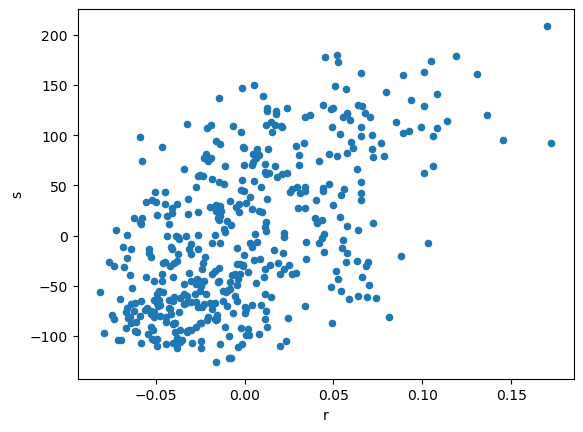

In [45]:
pd.DataFrame({'r': r, 's': s}).plot(kind='scatter', x='r', y='s')

## Multiple controls

- m1 = bmi ~ age + sex + bp + s1 + s2 + s3 + s4 + s5 + s6
- m2 = y ~ age + sex + bp + s1 + s2 + s3 + s4 + s5 + s6
- r1 = bmi - m1(age, sex, bp, s1, s2, s3, s4, s5, s6)
- r2 = y - m2(age, sex, bp, s1, s2, s3, s4, s5, s6)
- m3 = r2 ~ r1
- m = y ~ age + sex + bmi + bp + s1 + s2 + s3 + s4 + s5 + s6

In [51]:
m1 = LinearRegression()
m2 = LinearRegression()
m3 = LinearRegression()

m1.fit(X.drop(columns=['bmi']), X['bmi'])
m2.fit(X.drop(columns=['bmi']), y)

r1 = X['bmi'] - m1.predict(X.drop(columns=['bmi']))
r2 = y - m2.predict(X.drop(columns=['bmi']))

m3.fit(r1.to_frame(), r2)
m3.coef_

array([519.84592005])

In [53]:
m = LinearRegression()
m.fit(X, y)
pd.Series(m.coef_, X.columns)

age    -10.009866
sex   -239.815644
bmi    519.845920
bp     324.384646
s1    -792.175639
s2     476.739021
s3     101.043268
s4     177.063238
s5     751.273700
s6      67.626692
dtype: float64

## Double machine learning

In [54]:
from sklearn.ensemble import RandomForestRegressor

m1 = RandomForestRegressor(random_state=37, n_jobs=-1, n_estimators=10)
m2 = RandomForestRegressor(random_state=37, n_jobs=-1, n_estimators=10)
m3 = LinearRegression()

m1.fit(X.drop(columns=['bmi']), X['bmi'])
m2.fit(X.drop(columns=['bmi']), y)

r1 = X['bmi'] - m1.predict(X.drop(columns=['bmi']))
r2 = y - m2.predict(X.drop(columns=['bmi']))

m3.fit(r1.to_frame(), r2)
m3.coef_

array([508.34043333])

## Sample splitting

In [88]:
from sklearn.model_selection import KFold

def get_estimate(tr_index, te_index):
    X_tr, d_tr, y_tr = X.drop(columns=['bmi']).iloc[tr_index], X['bmi'].iloc[tr_index], y.iloc[tr_index]
    X_te, d_te, y_te = X.drop(columns=['bmi']).iloc[te_index], X['bmi'].iloc[te_index], y.iloc[te_index]
    
    m1 = RandomForestRegressor(random_state=37, n_jobs=-1, n_estimators=10)
    m2 = RandomForestRegressor(random_state=37, n_jobs=-1, n_estimators=10)
    m3 = LinearRegression()

    m1.fit(X_tr, d_tr)
    m2.fit(X_tr, y_tr)

    r1 = d_te - m1.predict(X_te)
    r2 = y_te - m2.predict(X_te)

    m3.fit(r1.to_frame(), r2)
    
    return m3.coef_[0]

splitter = KFold(n_splits=5, shuffle=True, random_state=37)
estimates = [get_estimate(tr_index, te_index) for tr_index, te_index in splitter.split(X)]
np.mean(estimates), np.std(estimates)

(505.9310167731861, 100.42630739883276)

In [95]:
from sklearn.model_selection import train_test_split

def get_estimate(d_col='bmi', random_state=37):
    X_tr, X_te, y_tr, y_te = train_test_split(X, y, shuffle=True, test_size=0.5, random_state=random_state)
    
    X_tr, d_tr = X_tr.drop(columns=[d_col]), X_tr[d_col]
    X_te, d_te = X_te.drop(columns=[d_col]), X_te[d_col]
    
    m1 = RandomForestRegressor(random_state=37, n_jobs=-1, n_estimators=10)
    m2 = RandomForestRegressor(random_state=37, n_jobs=-1, n_estimators=10)
    m3 = LinearRegression()

    m1.fit(X_tr, d_tr)
    m2.fit(X_tr, y_tr)

    r1 = d_te - m1.predict(X_te)
    r2 = y_te - m2.predict(X_te)

    m3.fit(r1.to_frame(), r2)
    
    return m3.coef_[0]

def estimate(d_col='bmi', max_iter=200):
    estimates = [get_estimate(d_col, i) for i in range(max_iter)]
    return {
        'variable': d_col,
        'estimate': np.mean(estimates),
        'std': np.std(estimates)
    }

pd.DataFrame([estimate(c) for c in X.columns])

,variable,estimate,std
0,age,2.107160,69.651271
1,sex,-205.918395,73.585760
2,bmi,495.455222,81.473690
3,bp,265.241904,71.549371
4,s1,-134.198358,313.943890
5,s2,-52.306987,286.652365
6,s3,-236.446231,163.779218
7,s4,97.210133,257.698259
8,s5,515.953055,113.054241
9,s6,83.226874,75.599235


## Double machine learning

In [107]:
from doubleml import DoubleMLData
from doubleml import DoubleMLPLR
from sklearn.base import clone

def get_model(d_col):
    np.random.seed(3141)
    data = DoubleMLData(
        X.assign(y=y),
        y_col='y',
        d_cols=d_col,
        x_cols=list(X.columns.drop([d_col]))
    )

    learner = RandomForestRegressor(random_state=37, n_jobs=-1, n_estimators=10)
    ml_l = clone(learner)
    ml_m = clone(learner)

    m = DoubleMLPLR(data, ml_l, ml_m)
    m.fit(store_models=True)
    
    return m

def get_summary(d_col):
    m = get_model(d_col)
    return m.summary

pd.concat([get_summary(c) for c in X.columns])

,coef,std err,t,P>|t|,2.5 %,97.5 %
age,-8.725229,59.042732,-0.147778,8.825178e-01,-124.446858,106.996400
sex,-198.485390,59.895497,-3.313862,9.201703e-04,-315.878408,-81.092373
bmi,448.273300,75.330901,5.950723,2.669611e-09,300.627447,595.919152
bp,271.593295,64.953301,4.181362,2.897675e-05,144.287163,398.899426
s1,-237.891157,237.396920,-1.002082,3.163040e-01,-703.180571,227.398256
s2,-115.889975,245.066520,-0.472892,6.362903e-01,-596.211528,364.431579
s3,-123.176182,150.923436,-0.816150,4.144143e-01,-418.980681,172.628317
s4,54.571481,218.437700,0.249826,8.027217e-01,-373.558543,482.701505
s5,507.240573,101.580684,4.993475,5.930256e-07,308.146091,706.335055
s6,101.971064,65.382567,1.559606,1.188529e-01,-26.176413,230.118540
